In [ ]:
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model
from keras import optimizers, initializers, regularizers, metrics
from tensorflow import keras
from tensorflow.keras import layers,Sequential
from tensorflow.keras.layers import Conv2D,Dropout,Dense,Dropout,Activation,MaxPooling2D,Flatten
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow_datasets as tfds
from keras.optimizers import Adam, RMSprop

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -qq '/content/drive/MyDrive/jebal/jebal-20221130T083609Z-001.zip' -d '/content/drive/MyDrive/jebal/'

In [ ]:
!unzip -qq '/content/drive/MyDrive/cars/원본car (1).zip' -d '/content/drive/MyDrive/cars'

In [ ]:
data_dir = '/content/drive/MyDrive/cars'
# prediction_dir = '/content/drive/MyDrive/for prediction/b/for prediction/'

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory( data_dir, 
                                                               validation_split=0.2, 
                                                               subset='training', 
                                                               labels='inferred', 
                                                               label_mode='categorical',
                                                               image_size=[224, 224], 
                                                               seed=123, 
                                                               interpolation='nearest',
                                                               batch_size=64, shuffle=True )

val_ds = tf.keras.preprocessing.image_dataset_from_directory( data_dir, validation_split=0.2, 
                                                             subset='validation', 
                                                             labels='inferred', 
                                                             label_mode='categorical', 
                                                             image_size=[224, 224], seed=123, 
                                                             interpolation='nearest', batch_size=64, 
                                                             shuffle=False )
class_names = train_ds.class_names

class_names

Found 9900 files belonging to 33 classes.
Using 7920 files for training.
Found 9900 files belonging to 33 classes.
Using 1980 files for validation.


['AVANTE',
 'CASPER',
 'EV6',
 'G70',
 'GRANDEUR',
 'GV60',
 'IONIQ5',
 'IONIQ6',
 'K5',
 'K8',
 'K9',
 'KONA',
 'Korando',
 'Morning',
 'NEXO',
 'NiroEV',
 'PALISADE',
 'Ray',
 'Rexton',
 'SANTAFE',
 'SONATA',
 'STARIA',
 'Seltos',
 'Sorento',
 'Sportage',
 'Stinger',
 'TUCSON',
 'Tivoli',
 'Torres',
 'VENUE',
 'qm6',
 'sm6',
 'xm3']

In [ ]:
def convert_to_float(image, label): 
  image = tf.image.convert_image_dtype(image, dtype=tf.float32) 
  return image, label


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE 
train_ds = (train_ds.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE)) 
val_ds = (val_ds.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE))

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(224, 
                                                              224,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

# mobilenet 8층부터

In [ ]:
#  model2 모델 만들기

base_model2 = MobileNet(weights='imagenet', include_top=False, input_shape=(224,224,3))

num = 1
for layer in base_model2.layers:
  if num > 7:
    layer.trainable = True
  num += 1

model2 = Sequential()

model2.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(224,224,3)))

model2.add(base_model2)

model2.add(Conv2D(16, 3, padding='same', activation='relu')) 
model2.add(MaxPooling2D(padding='same')) 
model2.add(Dropout(0.2))

model2.add(Conv2D(32, 3, padding='same', activation='relu')) 
model2.add(MaxPooling2D(padding='same'))

model2.add(Conv2D(64, 3, padding='same', activation='relu')) 
model2.add(MaxPooling2D(padding='same')) 
model2.add(Dropout(0.2))

model2.add(Flatten())

model2.add(Dense(128, activation='relu')) 
model2.add(Dense(33 , activation = 'softmax'))

model2.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

hist = model2.fit(train_ds,batch_size=64,epochs=20,validation_data=val_ds)

ValueError: ignored

In [ ]:
# model2 평가
model2.evaluate(train_ds),model2.evaluate(val_ds)

31/31 [==============================] - 2s 73ms/step - loss: 0.1174 - accuracy: 0.9677


([0.010555434972047806, 0.997474730014801],
 [0.11744493991136551, 0.9676767587661743])

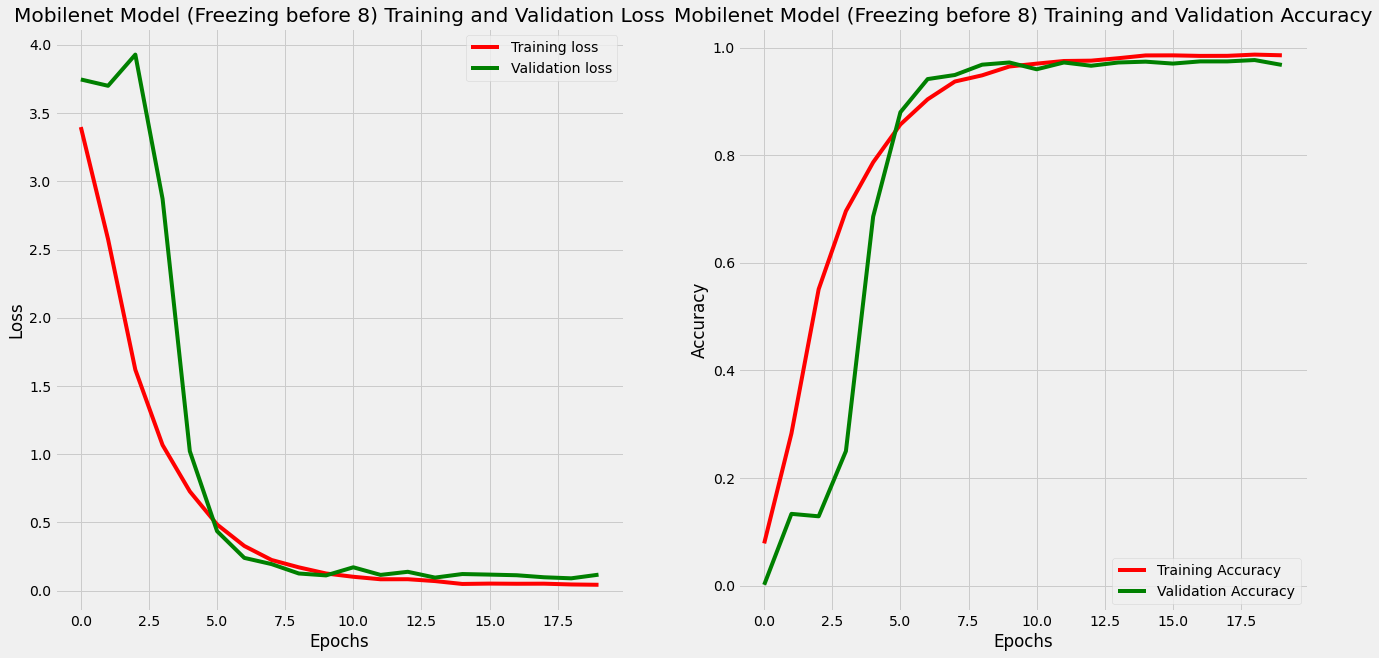

In [ ]:
# model2 시각화
plt.style.use('fivethirtyeight')
fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,10))
axes[0].plot(hist.history["loss"], 'r', label='Training loss')
axes[0].plot(hist.history["val_loss"],'g',label='Validation loss' )
axes[0].set_title('Mobilenet Model (Freezing before 8) Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[1].plot (hist.history["accuracy"],'r',label= 'Training Accuracy')
axes[1].plot (hist.history["val_accuracy"],'g',label= 'Validation Accuracy')
axes[1].set_title('Mobilenet Model (Freezing before 8) Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
plt.savefig("/content/drive/MyDrive/Colab Notebooks/Mobilenet_Freezing_8_accuracy.jpg")

In [ ]:
# model2 모델 저장
model2.save("/content/drive/MyDrive/Colab Notebooks/Mobilenet_Freezing_8.keras")

# mobilenet 15층부터

In [ ]:
# model3 모델 만들기
from tensorflow.keras.applications.mobilenet import MobileNet 
base_model3 = MobileNet(weights='imagenet', include_top=False, input_shape=(224,224,3)) # (본인이 전이학습 할 모델로 세팅)

num = 1
for layer in base_model3.layers:
  if num > 14:
    layer.trainable = True
  num += 1

model3 = Sequential()

model3.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(224,224,3)))

model3.add(base_model3)

model3.add(Conv2D(16, 3, padding='same', activation='relu')) 
model3.add(MaxPooling2D(padding='same')) 
model3.add(Dropout(0.2))

model3.add(Conv2D(32, 3, padding='same', activation='relu')) 
model3.add(MaxPooling2D(padding='same'))

model3.add(Conv2D(64, 3, padding='same', activation='relu')) 
model3.add(MaxPooling2D(padding='same')) 
model3.add(Dropout(0.2))

model3.add(Flatten())

model3.add(Dense(128, activation='relu')) 
model3.add(Dense(33 , activation = 'softmax'))

model3.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

hist = model3.fit(train_ds,batch_size=64,epochs=20,validation_data=val_ds)

Epoch 1/20
124/124 [==============================] - 72s 469ms/step - loss: 3.4112 - accuracy: 0.0736 - val_loss: 3.4448 - val_accuracy: 0.0293
Epoch 2/20
124/124 [==============================] - 57s 446ms/step - loss: 2.6012 - accuracy: 0.2620 - val_loss: 2.0903 - val_accuracy: 0.4934
Epoch 3/20
124/124 [==============================] - 57s 445ms/step - loss: 1.6605 - accuracy: 0.5179 - val_loss: 1.1278 - val_accuracy: 0.7318
Epoch 4/20
124/124 [==============================] - 56s 438ms/step - loss: 1.1017 - accuracy: 0.6773 - val_loss: 0.7714 - val_accuracy: 0.8056
Epoch 5/20
124/124 [==============================] - 60s 467ms/step - loss: 0.7749 - accuracy: 0.7631 - val_loss: 0.4697 - val_accuracy: 0.8859
Epoch 6/20
124/124 [==============================] - 56s 438ms/step - loss: 0.5361 - accuracy: 0.8376 - val_loss: 0.3070 - val_accuracy: 0.9283
Epoch 7/20
124/124 [==============================] - 56s 438ms/step - loss: 0.3978 - accuracy: 0.8756 - val_loss: 0.1851 - val_ac

In [ ]:
# model3 평가
model3.evaluate(train_ds),model3.evaluate(val_ds),

ValueError: ignored

In [ ]:
model3.evaluate(test_ds)

ValueError: ignored

In [ ]:
model3.save("/content/drive/MyDrive/Colab Notebooks/Mobilenet_Freezing_15_final.keras")

In [ ]:
(x,y),(xx,yy) = test_ds
from sklearn import metrics
predict = model3.predict(test_ds)
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior(y)
np_config.enable_numpy_behavior(yy)
y1 = y.tolist()
y2 = yy.tolist()
y3 = y1+y2
y_true = np.array(y3).reshape(99,-1)
confusion_matrix = metrics.confusion_matrix(y_true,predict)

2/2 [==============================] - 0s 75ms/step


ValueError: ignored